In [2]:
import torch
from torch import nn
import numpy as np
import random
from matplotlib import pyplot as plt

In [3]:
def distance_fun(distance):
    #初步先定为sigmoid函数
    return torch.sigmoid(distance)
    
    
def adaptive_position( query:torch.Tensor, key:torch.Tensor,position_ids=None)->torch.Tensor:
    '''输入的维度应该是 
    key: [batch, num_heads, seq_length, hidden_dim]
    
    in prefilling stage:
    query: [batch, num_heads, seq_length, hidden_dim]
    
    in inference stage:
    query: [batch, num_heads, 1, hidden_dim]'''
    batch,num_heads = query.shape[0], query.shape[1]
    if position_ids == None:
        #此时应该是预填充阶段
        #注意要错位相乘, 因此query要去第一个, key要去最后一个
        query = query[:,:,1:,:].unsqueeze(-2)
        key = key[:,:,:-1,:].unsqueeze(-2)
        distance = distance_fun(torch.matmul(query,key.transpose(-2,-1)).squeeze(-1)).transpose(-1,-2)
        
        #这个distance相比于真正的距离差着一个一号位, 我们都强制命令一号位的位置为0
        distance_0 = torch.zeros((batch,num_heads,1,1),dtype=distance.dtype)
        distance = torch.cat((distance_0,distance),dim=-1) #在一号位添加一个0
        
        position_ids = distance.cumsum(dim=-1)
    
    else:
        #这个时候的输入一般是"一个"query, 我们的任务是计算新的query和倒数第二个key之间的距离.
        
        new_distance = distance_fun(torch.matmul(query, key[:,:,1,:].transpose(-2,-1)))
        position_ids = new_distance + position_ids[:,:,:,-1]
    return position_ids
        
        


In [4]:
#修改它的block计算方式
def block_adaptive_position(query:torch.Tensor, key:torch.Tensor, position_ids=None,max_length = 256):
    if position_ids == None:
        position_ids = adaptive_position(query, key) % max_length
    else:
        position_ids = torch.cat((position_ids,adaptive_position(query,key,position_ids)),dim=-1) % max_length
    return position_ids
 


In [ ]:
x = torch.randn(1,1,1000,3)
y = torch.randn(1,1,1000,3)
block_adaptive_position(x,y)

In [3]:
llama_dir = '/mntcephfs/data/ruoyusun/liziniu/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-hf/snapshots/8a0442e81540efaeb1a0fe3e95477b5e0edfd423'
from transformers import LlamaForCausalLM
llama = LlamaForCausalLM.from_pretrained(llama_dir,attn_implementation="eager")

/mntcephfs/lab_data/hanyizhou/anaconda/pe/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/mntcephfs/lab_data/hanyizhou/anaconda/pe/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
wte = llama.model.embed_tokens.weight
relative_matrix = wte@wte.T
relative_matrix = relative_matrix.detach().numpy()

In [15]:
def rand_sample(N, matrix):
    row, col = matrix.shape
    x = random.sample(list(range(row)), N)
    y = random.sample(list(range(col)), N)
    return matrix[x,y]

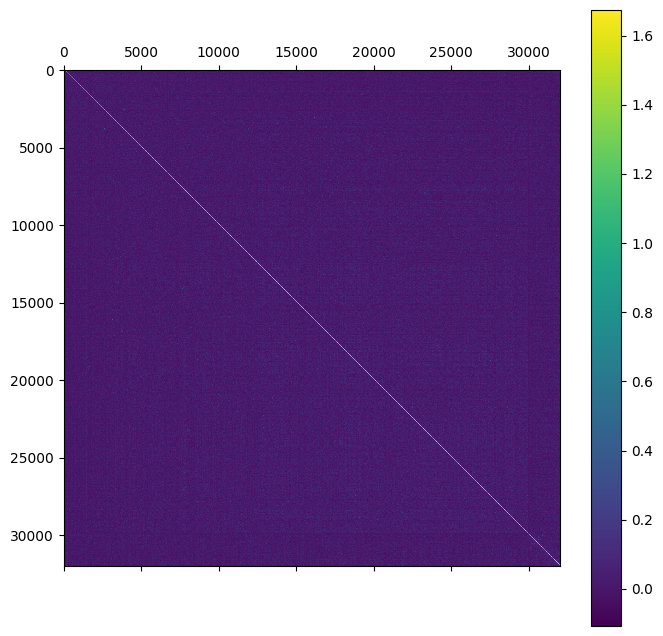

In [32]:
fig,ax = plt.subplots(1,1,figsize = (8,8))
im = ax.matshow(relative_matrix)
plt.colorbar(im,ax=ax)